# Training GCN

This notebook shows how to train the anomaly detection model.

In [52]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GraphAE
from parameters import GraphAEParameters, TrainingParameters
from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

### Time Series Sequencing

In [53]:
def sequence_gcnae(data, timesteps, hide_anomalies=True):
    sequence = []
    static_edges = generate_edges(milemarkers=list(range(49)))
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times)):
        data_t = []
        contains_anomaly = np.any([np.unique(data[data['unix_time']==t]['anomaly'])[0]])

        if (hide_anomalies and contains_anomaly):
            continue
        
        kept_indices.append(index)

        data_t.append(data[data['unix_time']==t][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not
        
        curr_data = data_t[-1]
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append(curr_graph)

    return sequence, kept_indices

### Loading Hyperparameters

In [54]:
optimal_hyperparams = load_best_parameters('gcn_v2')

In [55]:
optimal_hyperparams

{'dropout': 0.03472588957921531,
 'epochs': 10,
 'gcn_hidden_dim': 64,
 'latent_dim': 128,
 'learning_rate': 0.0004708326073117493,
 'num_gcn': 1,
 'timesteps': 2}

In [56]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [57]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=0,
    n_epochs=1
)

In [58]:
train_data, test_data, _ = get_full_data()
train_data = normalize_data(train_data)
train_data = label_anomalies(train_data)
train_sequence, kept_train_indices = sequence_gcnae(train_data, training_params.timesteps)

100%|██████████| 13440/13440 [00:32<00:00, 419.76it/s]


In [59]:
hyperparams = GraphAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_gcn=optimal_hyperparams['num_gcn']
)

In [60]:
ae = GraphAE(hyperparams)

In [61]:
ae(train_sequence[0]).shape

torch.Size([196, 3])

### Model Training or Loading

In [62]:
using_pretrained = True

In [63]:
if not using_pretrained:
    ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, 'gcn')
else:
    ae = load_model(GraphAE, hyperparams, 'gcn')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:07<00:00, 67.55s/it]

Epoch number 0 last 100 loss 0.007954888429958373


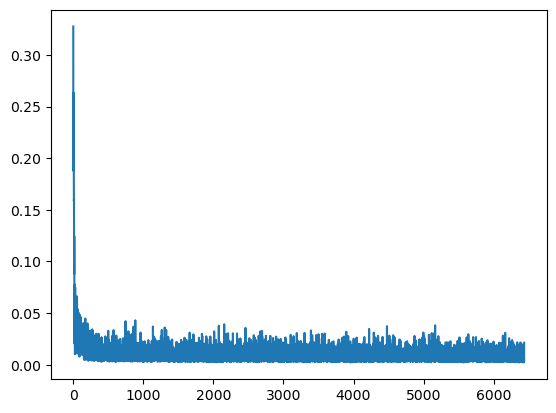

In [64]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [65]:
thresh = compute_anomaly_threshold_gcnae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 6436/6436 [00:18<00:00, 351.55it/s]


### Loading Test Data

In [66]:
_, df_test_data, _ = get_full_data()

In [67]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gcnae(test_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/4800 [00:00<?, ?it/s]

100%|██████████| 4800/4800 [00:05<00:00, 948.58it/s]


In [68]:
test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

In [69]:
np.mean(test_errors)

0.012674843

In [70]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

### Compute FPR / Crash Detection Delay Tradeoff

In [71]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 98/98 [00:00<00:00, 102.59it/s]


In [72]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/gcnae_fp_delay.csv')

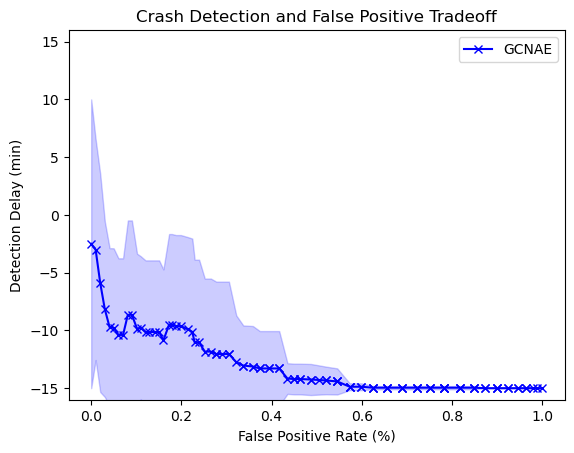

In [73]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='GCNAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [74]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [01:05<00:00, 15.19it/s]

FPR 1% gives mean delay of -3.0 +/- 9.561828874675149 while missing 0.41666666666666663%.
FPR 2.5% gives mean delay of -6.666666666666667 +/- 9.171210994798404 while missing 0.25%.
FPR 5% gives mean delay of -9.777777777777779 +/- 6.8884408456450155 while missing 0.25%.
FPR 10% gives mean delay of -9.85 +/- 6.496345126299865 while missing 0.16666666666666663%.
FPR 20% gives mean delay of -9.625 +/- 7.882271774896711 while missing 0.0%.


### Compute AUC

In [75]:
calculate_auc(test_errors, anomaly_labels)

0.6995019383068928

### Copmute Detection Delay Histogram on Full Dataset

In [76]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [77]:
full_sequence, kept_full_indices = sequence_gcnae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/18240 [00:00<?, ?it/s]

100%|██████████| 18240/18240 [01:18<00:00, 231.86it/s]


In [78]:
full_errors, _, _ = test_gcnae(full_sequence, mse_weights, ae)

In [79]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

In [80]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


In [81]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


In [82]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

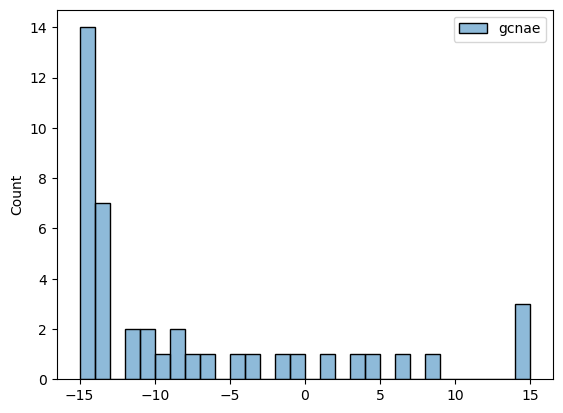

In [83]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='gcnae')
plt.legend()

In [84]:
np.save('./saved_results/gcnae10delays.npy', np.array(delay)/2)

In [85]:
_, df_clean_test_data, _ = get_full_data()

In [86]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_gcnae(clean_test_data, training_params.timesteps, hide_anomalies=True)

100%|██████████| 4800/4800 [00:02<00:00, 1651.97it/s]


In [87]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_gcnae(clean_test_data, mse_weights, ae)

In [88]:
np.mean(clean_test_errors)

0.009457098

In [89]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [90]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [91]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [92]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [93]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()